# In this NLP project, we are going to perform Sentiment Analysis on a Movie Review Dataset.
<p style="font-size: larger;"> The dataset has two primary files 'train.tsv' and 'test.tsv'</p>

In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import numpy as np

2024-03-28 06:00:32.789964: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-28 06:00:32.790110: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-28 06:00:32.924965: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [60]:
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

# Converting the TSV files into CSV files

<p style="font-size: larger;"> As Tab Seperated Values (TSV) is kind of Comman Seperated Value (CSV) where the delimiter is a <b>tab space</b>, if we set the delimiter as '/t' and then read the tsv file, we will cut and make a entry in the csv file every time we encounter a tab space in the TSV file </p>

<p style="font-size: larger;">The function takes the name of the CSV and the TSV file as input and then reads the TSV file and writes it on the CSV file, keeping the delimiter in mind </p>

In [4]:
def tsv_to_csv(tsv_file, csv_file):
    with open(tsv_file, 'r', newline='') as tsvfile:
        tsvreader = csv.reader(tsvfile, delimiter='\t')
        with open(csv_file, 'w', newline='') as csvfile:
            csvwriter = csv.writer(csvfile)
            for row in tsvreader:
                csvwriter.writerow(row)

In [5]:
# converting the train.tsv to train.csv
tsv_to_csv ('/kaggle/input/training-dataset/train.tsv','train.csv')

#coverting the test.tsv to train.csv
tsv_to_csv ('/kaggle/input/testing-dataset/test.tsv','test.csv')

# Creating the dataframe

In [6]:
df_train = pd.read_csv('/kaggle/working/train.csv')
df_train

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
...,...,...,...,...
156055,156056,8544,Hearst 's,2
156056,156057,8544,forced avuncular chortles,1
156057,156058,8544,avuncular chortles,3
156058,156059,8544,avuncular,2


In [7]:
df_test = pd.read_csv('/kaggle/working/test.csv')
df_test

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine
...,...,...,...
66287,222348,11855,"A long-winded , predictable scenario ."
66288,222349,11855,"A long-winded , predictable scenario"
66289,222350,11855,"A long-winded ,"
66290,222351,11855,A long-winded


In [8]:
y_test = pd.read_csv('/kaggle/input/y-test/sampleSubmission.csv')
y_test

,PhraseId,Sentiment
0,156061,2
1,156062,2
2,156063,2
3,156064,2
4,156065,2
...,...,...
66287,222348,2
66288,222349,2
66289,222350,2
66290,222351,2


In [9]:
df_train['Sentiment'].unique()

array([1, 2, 3, 4, 0])

<font size ='3'> We can see that there are 4  different labels for the sentiments; they are: <br>
    <b>
    0 - negative <br>
    1 - somewhat negative <br>
    2 - neutral <br>
    3 - somewhat positive <br>
    4 - positive <br>
    </b>

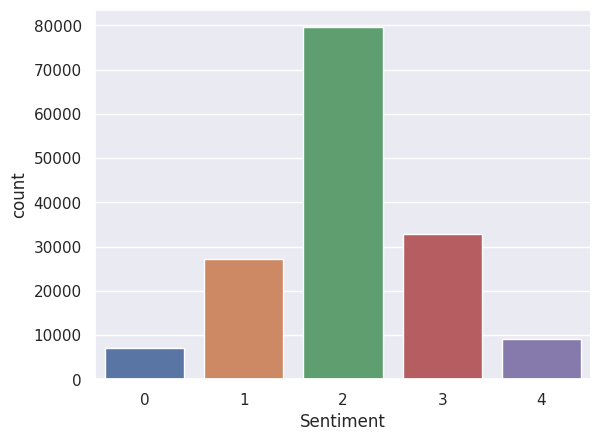

In [10]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Sentiment", data=df_train)

# Data Preprocessing

<p style="font-size: larger;"> Now we will perform data preprocessing on this dataset, the entire preprocessing will happen on the review, such as lemmatizing and stemming it, removing the stop words and the punctuations, etc. </p>

In [37]:
nlp = spacy.load('en_core_web_sm')

def preprocess(text):
    
    if isinstance(text, float) and np.isnan(text):
        return ''
    doc = nlp(text)
    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_)
    
    return " ".join(filtered_tokens) 

<p style="font-size: larger;"> We will now extract the reviews from each dataframe into a list, then send the entire list, preprocess it, perform all the actions, make a new list, and later, we will append/attack the new list into the dataframe </p>

In [12]:
reviews = df_train['Phrase'].tolist()
reviews

['A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .',
 'A series of escapades demonstrating the adage that what is good for the goose',
 'A series',
 'A',
 'series',
 'of escapades demonstrating the adage that what is good for the goose',
 'of',
 'escapades demonstrating the adage that what is good for the goose',
 'escapades',
 'demonstrating the adage that what is good for the goose',
 'demonstrating the adage',
 'demonstrating',
 'the adage',
 'the',
 'adage',
 'that what is good for the goose',
 'that',
 'what is good for the goose',
 'what',
 'is good for the goose',
 'is',
 'good for the goose',
 'good',
 'for the goose',
 'for',
 'the goose',
 'goose',
 'is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .',
 'is also good for the gander , some of which occasionally amuses but none of 

<p style="font-size: larger;">Now we will send all these reviews for preprocessing, we will use <i><b> basic list comprehension</b></i> to send the phrases/reviews one by one</p>

In [13]:
reviews_processed = [preprocess(text) for text in reviews]
reviews_processed

['series escapade demonstrate adage good goose good gander occasionally amuse amount story',
 'series escapade demonstrate adage good goose',
 'series',
 '',
 'series',
 'escapade demonstrate adage good goose',
 '',
 'escapade demonstrate adage good goose',
 'escapade',
 'demonstrate adage good goose',
 'demonstrate adage',
 'demonstrate',
 'adage',
 '',
 'adage',
 'good goose',
 '',
 'good goose',
 '',
 'good goose',
 '',
 'good goose',
 'good',
 'goose',
 '',
 'goose',
 'goose',
 'good gander occasionally amuse amount story',
 'good gander occasionally amuse amount story',
 '',
 '',
 'good gander occasionally amuse amount story',
 'gander occasionally amuse amount story',
 'gander occasionally amuse amount story',
 'gander',
 'gander',
 'gander',
 '',
 'occasionally amuse amount story',
 '',
 '',
 '',
 '',
 'occasionally amuse amount story',
 'occasionally',
 'amuse amount story',
 'amuse',
 'amount story',
 '',
 'amount story',
 '',
 'amount story',
 'amount story',
 'amount story',

In [14]:
df_train['Review'] = reviews_processed
df_train

,PhraseId,SentenceId,Phrase,Sentiment,Review
0,1,1,A series of escapades demonstrating the adage ...,1,series escapade demonstrate adage good goose g...
1,2,1,A series of escapades demonstrating the adage ...,2,series escapade demonstrate adage good goose
2,3,1,A series,2,series
3,4,1,A,2,
4,5,1,series,2,series
...,...,...,...,...,...
156055,156056,8544,Hearst 's,2,Hearst
156056,156057,8544,forced avuncular chortles,1,force avuncular chortle
156057,156058,8544,avuncular chortles,3,avuncular chortle
156058,156059,8544,avuncular,2,avuncular


<p style="font-size: larger;"> We can see that now, there are rows that will have whitespaces left <b> ( ' ' ) </b>. This might result in loss of data, that may later on affect the accuracy of the model</p>

<p style="font-size: larger;"> The presence of whitespaces must <b>not</b> be misunderstood to the value at that row being NULL. <br>
    If it is a NULL Value then, there is nothing present at that row in the Review coloumn, but we actually have white spaces present there. <br>
    Hence, if we perform <i><b>df_train['Review'].isnull()</b></i> we will see that it will show False, meaning that there is no null value there.</p>

<p style="font-size: larger;"> We will also drop all the unnecessary columns such as the <b><i> PhraseId, SentenceId and Phrase (the not preprocessed column) </i> </b> </p>

In [15]:
df_train = df_train.drop(['PhraseId','SentenceId','Phrase'],axis=1)
df_train

,Sentiment,Review
0,1,series escapade demonstrate adage good goose g...
1,2,series escapade demonstrate adage good goose
2,2,series
3,2,
4,2,series
...,...,...
156055,2,Hearst
156056,1,force avuncular chortle
156057,3,avuncular chortle
156058,2,avuncular


<p style="font-size: larger;"> Now we will perform the same preprocessing for the test dataset </p>

In [31]:
reviews_test = df_test['Phrase'].tolist()
reviews_test

['An intermittently pleasing but mostly routine effort .',
 'An intermittently pleasing but mostly routine effort',
 'An',
 'intermittently pleasing but mostly routine effort',
 'intermittently pleasing but mostly routine',
 'intermittently pleasing but',
 'intermittently pleasing',
 'intermittently',
 'pleasing',
 'but',
 'mostly routine',
 'mostly',
 'routine',
 'effort',
 '.',
 "Kidman is really the only thing that 's worth watching in Birthday Girl , a film by the stage-trained Jez Butterworth -LRB- Mojo -RRB- that serves as yet another example of the sad decline of British comedies in the post-Full Monty world .",
 'Kidman',
 "is really the only thing that 's worth watching in Birthday Girl , a film by the stage-trained Jez Butterworth -LRB- Mojo -RRB- that serves as yet another example of the sad decline of British comedies in the post-Full Monty world .",
 "is really the only thing that 's worth watching in Birthday Girl , a film by the stage-trained Jez Butterworth -LRB- Mojo -

In [38]:
reviews_test_processed = [preprocess(text) for text in reviews_test]
reviews_test_processed

['intermittently pleasing routine effort',
 'intermittently pleasing routine effort',
 '',
 'intermittently pleasing routine effort',
 'intermittently pleasing routine',
 'intermittently pleasing',
 'intermittently pleasing',
 'intermittently',
 'pleasing',
 '',
 'routine',
 '',
 'routine',
 'effort',
 '',
 'Kidman thing worth watch Birthday Girl film stage train Jez Butterworth -LRB- Mojo -RRB- serve example sad decline british comedy post monty world',
 'Kidman',
 'thing worth watch Birthday Girl film stage train Jez Butterworth -LRB- Mojo -RRB- serve example sad decline british comedy post monty world',
 'thing worth watch Birthday Girl film stage train Jez Butterworth -LRB- Mojo -RRB- serve example sad decline british comedy post monty world',
 '',
 '',
 '',
 'thing worth watch Birthday Girl film stage train Jez Butterworth -LRB- Mojo -RRB- serve example sad decline british comedy post monty world',
 'thing',
 '',
 'thing',
 '',
 'thing',
 'worth watch Birthday Girl film stage trai

In [39]:
df_test['Review'] = reviews_test_processed
df_test

,PhraseId,SentenceId,Phrase,Review
0,156061,8545,An intermittently pleasing but mostly routine ...,intermittently pleasing routine effort
1,156062,8545,An intermittently pleasing but mostly routine ...,intermittently pleasing routine effort
2,156063,8545,An,
3,156064,8545,intermittently pleasing but mostly routine effort,intermittently pleasing routine effort
4,156065,8545,intermittently pleasing but mostly routine,intermittently pleasing routine
...,...,...,...,...
66287,222348,11855,"A long-winded , predictable scenario .",long wind predictable scenario
66288,222349,11855,"A long-winded , predictable scenario",long wind predictable scenario
66289,222350,11855,"A long-winded ,",long winded
66290,222351,11855,A long-winded,long winded


In [41]:
df_test = df_test.drop(['PhraseId','SentenceId','Phrase'],axis=1)
df_test

,Review
0,intermittently pleasing routine effort
1,intermittently pleasing routine effort
2,
3,intermittently pleasing routine effort
4,intermittently pleasing routine
...,...
66287,long wind predictable scenario
66288,long wind predictable scenario
66289,long winded
66290,long winded


In [45]:
y_test = y_test.drop(['PhraseId'],axis=1)
y_test

,Sentiment
0,2
1,2
2,2
3,2
4,2
...,...
66287,2
66288,2
66289,2
66290,2


In [76]:
x_train = df_train['Review']
y_train = df_train['Sentiment']
x_test = df_test['Review']
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(156060,)
(156060,)
(66292,)
(66292, 1)


# Model Training

<p style="font-size: larger;"> We will train <b>TWO</b> different models:</p>
<ul style="font-size: larger;">
  <li>The first model will perform the classifications using Logistic Regression</li>
  <li>The second model will perform classifications using random forests</li>
</ul>


# Model Trained for classification using Logistic Regression

<p style="font-size: larger;"> Firstly we will use a count vectorizer that will create a sparse matrix of the sentences that are present in the dataset. As it is a sparse matrix there is no need for us to scale it useing Standard Scalar.<br>
<br>
Later we will perform Logisitic Regression on the model, and we will set the maximum number of iterations to 1000. This is because if we do not increase the number of iterations, the optimizing function that is used in Logistic Regression (Limited-memory Broyden-Fletcher-Goldfarb-Shanno algorithm, LBFGS), will not be able to converge, and that would show us the below shown error:<br>
<br>
<i> /opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
    STOP: TOTAL NO. of ITERATIONS REACHED LIMIT. </i>
</p>

In [114]:
model_logistic = Pipeline([
    ('BoW', CountVectorizer()),
    ('LogisticRegression', LogisticRegression(max_iter=1000))
])

In [115]:
model_logistic.fit(x_train, y_train)

Pipeline(steps=[('BoW', CountVectorizer()),
                ('LogisticRegression', LogisticRegression(max_iter=1000))])

In [116]:
print("Accuracy:",accuracy_score(y_test,model_logistic.predict(x_test)))

Accuracy: 0.6872925843239003


<p style="font-size: larger;"> We can see that the accuracy of the model is coming around 69%, This could probably be because of the lost of data due to whitesapces coming up after the data was preprocessed </p>

# Model Trained for classification using Random Forest

In [117]:
model_random_forest = Pipeline(
    [
        ('BoW',CountVectorizer()),
        ('Random_Forest',RandomForestClassifier(n_estimators=100,criterion='entropy'))
    ]
)

In [121]:
model_random_forest.fit(x_train, y_train)

Pipeline(steps=[('BoW', CountVectorizer()),
                ('Random_Forest', RandomForestClassifier(criterion='entropy'))])

In [122]:
print("Accuracy:",accuracy_score(y_test,model_random_forest.predict(x_test)))

Accuracy: 0.7085922886622821
